In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from tensorflow.python.client import timeline
%matplotlib inline


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [9]:
from tensorflow.examples.tutorials.mnist import input_data
mnist=input_data.read_data_sets("MNIST_data/", one_hot=True)
X_tr=mnist.train.images
Y_tr=mnist.train.labels
X_te=mnist.test.images
Y_te=mnist.test.labels
X_val=mnist.validation.images
Y_val=mnist.validation.labels

P=np.shape(X_tr)[1]
permutation=np.random.permutation(P)

X_tr=X_tr[:,permutation]
X_te=X_te[:,permutation]
X_val=X_val[:,permutation]

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## Class to compute the ESN response

The input should be:
<ul>
    <li> alpha1, alpha2: leakage term of the reservoir 1 and 2 </li>
    <li> pho1, pho2: $\rho$ of the reservoir 1 and 2 </li>
    <li> diluition1, diluition2: probability of a zero in the connectivity matrix of ESN 1 and 2 </li> 
    <li> N1, N2: number of nodes of ESN 1 and 2 </li>
    <li> W1_in, W2_in: input connectivity matrix of ESN 1 and 2 </li>
    <li> gamma12: multiplicative factor of the connectivity matrix between the two ESN
    <li> T_conc: the multiples of T_conc define the values for the readout </li>
    
</ul>

Note: ESN 1 is the 'deeper' one and receives input from ESN 2 in the case of hierarchical structure

In [22]:
class Echo:
    
    def __init__(self,alpha1, pho1, diluition1, N1, W1_in,
                         alpha2, pho2, diluition2, N2, W2_in, gamma12, T_conc):
                
            ## Reservoir 1
        
            self.N1=N1
            
            ## alpha 1
            self.alpha1=tf.constant(alpha1,dtype=tf.float32)
            
            ## W1 def
            W1_np=np.random.uniform(-1,1,[N1,N1])
            D=np.random.uniform(0,1,(N1,N1))>np.ones((N1,N1))*diluition1
            W1_np=W1_np*D.astype(int)
            
            eig1=np.linalg.eigvals(W1_np)

            W1_np=pho1*W1_np/(np.max(np.absolute(eig1)))
            self.W1=tf.Variable(W1_np,trainable=False,dtype=tf.float32)
            
            
            self.eig1=eig1
            
            ## Input W
            self.W1_in=tf.Variable(W1_in,trainable=False,dtype=tf.float32)
            
            
            ## Reservoir 2
            
            self.N2=N2
            
            ## alpha 2
            self.alpha2=tf.constant(alpha2,dtype=tf.float32)
            
            ## W2 def
            W2_np=np.random.uniform(-1,1,[N2,N2])
            D=np.random.uniform(0,1,(N2,N2))>np.ones((N2,N2))*diluition2
            W2_np=W2_np*D.astype(int)

            eig2=np.linalg.eigvals(W2_np)
            
            W2_np=pho2*W2_np/(np.max(np.absolute(eig2)))
            self.W2=tf.Variable(W2_np,trainable=False,dtype=tf.float32)    
                     
            ## Input W    
            self.W2_in=tf.Variable(W2_in,trainable=False,dtype=tf.float32)
            
            ## Reservoir 2 to Reservoir 1
            
            W12=gamma12*np.random.randn(N2,N1)
            
            self.W12=tf.Variable(W12,trainable=False,dtype=tf.float32)
            
            ## The multiples of T_conc are the values of t at which the ESN representations are concatenated
            self.T_conc=T_conc
            
    def train_graph(self,T,init_state1,init_state2,inputs,return_all=False):

        
        state1=init_state1
        states_train1=[]
        
        state2=init_state2
        states_train2=[]

        
        
        for t in range(T):
            
            prev_state1=tf.identity(state1)
            prev_state2=tf.identity(state2)
            
            state1 = (1-self.alpha1)*prev_state1+self.alpha1*tf.tanh( tf.matmul(prev_state1,self.W1)\
                                                    
                                                                     +tf.matmul(prev_state2,self.W12)\
                                                                     
                                                                     +tf.tile(tf.expand_dims(inputs[:,t],1),[1,self.N1])*self.W1_in )
                                                    
           
            state2 = (1-self.alpha2)*prev_state2+self.alpha2*tf.tanh( tf.matmul(prev_state2,self.W2)\
                                                                     
                                                                     +tf.tile(tf.expand_dims(inputs[:,t],1),[1,self.N2])*self.W2_in )
            
            
            if return_all:
                
                states_train1.append(state1)
                
                states_train2.append(state2)
                
            elif (t+1)%self.T_conc==0:
                
                states_train1.append(state1)
                
                states_train2.append(state2)
                
                
        states1=tf.concat([tf.expand_dims(s,2) for s in states_train1],2)
        
        states2=tf.concat([tf.expand_dims(s,2) for s in states_train2],2)
        
        states=tf.concat([states1,states2],axis=1)
        
        return states, states1, states2
    

## Definition of the input connectivity matrices
In the case of hierarchical ESN, W1_In will be set to zero

In [23]:
def W_input(N1,N2):

    W1_In=np.ones(N1)
    W1_In[np.random.uniform(0,1,N1)<0.5]=-1
    
    W2_In=np.ones(N2)
    W2_In[np.random.uniform(0,1,N2)<0.5]=-1
    W2_In=W2_In 
    
    return W1_In, W2_In

## ESN representation over the dataset

The data are splitted because of the limited memory in my gpu

In [24]:
## ESN representation over the dataset
def Echo_representations(alpha1, pho1, diluition1, N1, W1_in,
                             alpha2, pho2, diluition2, N2, W2_in, gamma12, 
                             X_tr, X_val, X_test, T_size):

    T=np.shape(X_tr)[1]
    N_class=np.shape(Y_tr)[1]
    
    T_conc=np.int(T/T_size)
    
    rnn=Echo(alpha1, pho1, diluition1, N1, W1_in,
                alpha2, pho2, diluition2, N2, W2_in, gamma12, T_conc)

    init_state1=tf.placeholder(tf.float32,[None,N1])
    init_state2=tf.placeholder(tf.float32,[None,N2])
    s=tf.placeholder(tf.float32,[None,T])

    states, states1, states2=rnn.train_graph(T,init_state1,init_state2,s,return_all=False)

    init=tf.global_variables_initializer()

    train_divide=100
    N_train_d=int(np.floor(np.shape(Y_tr)[0]/train_divide))

    test_divide=50
    N_test_d=int(np.floor(np.shape(Y_te)[0]/test_divide))
    
    val_divide=50
    N_val_d=int(np.floor(np.shape(Y_val)[0]/val_divide))

    States=np.zeros([N_train_d*train_divide,N,T_size])
    States_test=np.zeros([N_test_d*test_divide,N,T_size])
    States_val=np.zeros([N_val_d*val_divide,N,T_size])

    with tf.Session() as sess:

        sess.run(init)
        
        print('Training Data')

        for l in range(train_divide):

            images=np.copy(X_tr[l*N_train_d:(l+1)*N_train_d,:])

            states_=sess.run(states,feed_dict={init_state1:np.zeros([N_train_d,N1]),init_state2:np.zeros([N_train_d,N2]),s:images})

            States[l*N_train_d:(l+1)*N_train_d,:,:]=states_

            
        print('Testing Data')

        for l in range(test_divide):

            images=np.copy(X_te[l*N_test_d:(l+1)*N_test_d,:])

            states_=sess.run(states,feed_dict={init_state1:np.zeros([N_test_d,N1]),init_state2:np.zeros([N_test_d,N2]),s:images})

            States_test[l*N_test_d:(l+1)*N_test_d,:,:]=states_    
            
       
        print('Validating Data')

        for l in range(val_divide):

            images=np.copy(X_val[l*N_val_d:(l+1)*N_val_d,:])

            states_=sess.run(states,feed_dict={init_state1:np.zeros([N_val_d,N1]),init_state2:np.zeros([N_val_d,N2]),s:images})

            States_val[l*N_val_d:(l+1)*N_val_d,:,:]=states_
        
    
    return States, States_test, States_val


## Tensorflow graph for the training

The following class handles the training of 2 possible models:

<ul>
    <li> SpaRCe: training of N_copies NNs starting from different initial conditions, i.e. different starting sparsity level.            The algorithm is composed by an initialisation phase (it initialises the starting value of the thresholds, theta_g)            and a training phase (where the thresholds theta_i and the output weights W_out are optimised). The thresholds are              theta=theta_g+theta_i, where the first factor corresponds to the initialisation, and the second factor is optimised            (this split is due to convenience, to have the possibility to check each factor separately)  </li>
    <li> ESN: Training of the readout of an ESN. It is possible to compute the performance as the learning rate varies by                selecting scan=True. </li>
 </ul>
 
The hyperparameters suggested are already in a good configuration. 
 

In [28]:
class Models:
    
    def __init__(self,N,T_size,N_class,alpha_size,batch_size,N_ep):
        
        self.T=T_size
        
        self.N=N
        
        self.N_class=N_class
        
        self.alpha_size=alpha_size
        
        self.batch_size=batch_size
        
        self.N_episodes=N_ep
        
        
    def ESN(self,state,y_true,scan,N_copies):
        
        if scan==False:
    
            alpha_sizes=[self.alpha_size]
                               
        
        if scan==True:
            
            alpha_sizes=0.002*2**(-np.linspace(0,4,5))
            
        W_out=[]
        y=[]
        error=[]
        train=[]

        for i in range(N_copies):

            W_out.append(tf.Variable(np.random.uniform(-1,1,[self.N*self.T,self.N_class])/(self.N/10),dtype=tf.float32))

            y.append( tf.matmul(state,W_out[i]) )

            error.append(tf.losses.sigmoid_cross_entropy(y_true,y[i]))

            train.append(tf.train.AdamOptimizer(learning_rate=alpha_sizes[i]).minimize(error[i],var_list=[W_out[i]]))


        return y, error, train 
    
    def SpaRCe(self,state,y_true,theta_g_start):
        
        theta_g=[]
        theta_i=[]
        W_out=[]
        state_sparse=[]
        y=[]
        error=[]
        train1=[]
        train2=[]
                
        theta_istart=np.random.randn(N,self.T)/N
        theta_istart=np.reshape(theta_istart,[-1,N*self.T])

        for i in range(N_copies):

            theta_g.append(tf.Variable(theta_g_start[i], trainable=False, dtype=tf.float32))

            theta_i.append(tf.Variable(theta_istart,dtype=tf.float32))

            W_out.append(tf.Variable(np.random.uniform(0,1,[self.N*self.T,N_class])/(N),dtype=tf.float32))
            
            state_sparse.append(tf.sign(state)*tf.nn.relu(tf.abs(state)-theta_g[i]-theta_i[i]))     

            y.append(tf.matmul(state_sparse[i],W_out[i]))

            error.append(tf.losses.sigmoid_cross_entropy(y_true,y[i]))
    
            train1.append(tf.train.AdamOptimizer(learning_rate=alpha_size).minimize(error[i],var_list=[W_out[i]]))
            train2.append(tf.train.AdamOptimizer(learning_rate=alpha_size/10).minimize(error[i],var_list=[theta_i[i]]))

            train=train1+train2
        
        
        return state_sparse, y, error, train
        

## Computation of ESNs representation

Training Data
Testing Data
Validating Data


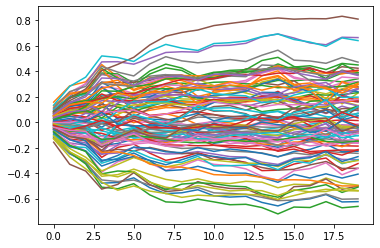

In [26]:
N1=500
N2=300
N=N1+N2

N_class=10

T_size=28                                # Number of hidden states used for the readout (they are equally spaced across the input sequence)

alpha1=0.017
alpha2=1

pho1=0.99                                # Value of \rho for ESN 1
pho2=1                                   # Value of \rho for ESN 2

N1_av=5                                  # Average number of connections for a node in ESN 1
N2_av=3                                  # Average number of connections for a node in ESN 2

diluition1=1-N1_av/N1                    # Probability of a zero in the connectivity matrix of ESN 1
diluition2=1-N2_av/N2                    # Probability of a zero in the connectivity matrix of ESN 2

gamma12=0.15 # Multiplicative factor of the connectivity between the reservoirs
gamma1=0     # Multiplicative factor of the input connectivity to ESN 1

W1_in,W2_in=W_input(N1,N2)
W1_in=gamma1*W1_in.T

Data_train, Data_test, Data_val=Echo_representations(alpha1, pho1, diluition1, N1, W1_in,
                                 alpha2, pho2, diluition2, N2, W2_in, gamma12, 
                                 X_tr, X_val, X_te, T_size)

show_example=True

if show_example:
    for i in range(100):
        plt.plot(Data_train[0,i,0:20])





## TRAINING

It is possible to specify the model to train (SpaRCe or readout of ESN).

In [53]:
tf.reset_default_graph()


N_episodes=300000
N_check=100
N_class=10


N_train=np.shape(X_tr)[0]

T_size=np.shape(Data_train)[2]
N_class=np.shape(Y_tr)[1]
N_proj=np.shape(X_tr)[1]

train_divide=10

N_train_d=int(np.floor(np.shape(Y_tr)[0]/train_divide))

test_divide=5

N_test_d=int(np.floor(np.shape(Y_te)[0]/test_divide))


MODEL=2

if MODEL==1:
    
    alpha_size=0.002                                                  # Learning rate
    batch_size=20    
    NN_model=Models(N,T_size,N_class,alpha_size,batch_size,N_episodes)
    
    theta_g_start=[]
    
    N_copies=5
    
    
    # INITIALISATION
    for n in range(N_copies):

        theta_g_start_help=np.zeros([N,T_size])

        for t in range(T_size):

            state_help=Data_train[:,:,t]

            theta_g_start_help[:,t]=np.percentile(np.abs(state_help),(100/N_copies)*n,0)
            
        theta_g_start.append(np.reshape(theta_g_start_help,[-1,T_size*N]))
    
    States_tr=np.reshape(Data_train,[-1,N*T_size])
    States_te=np.reshape(Data_test,[-1,N*T_size])
    
    s=tf.placeholder(tf.float32,[None,N*T_size])
    y_true=tf.placeholder(tf.float32,[None,N_class])

    state_sparse, y, error, train = NN_model.SpaRCe(s,y_true,theta_g_start)
    
if MODEL==2:
    
    alpha_size=0.0005                                               # Learning rate
    batch_size=20
    
    N_copies=5
    scan=False
    
    if scan==False:
        N_copies=1
    
    NN_model=Models(N,T_size,N_class,alpha_size,batch_size,N_episodes)
    
    States_tr=np.reshape(Data_train,[-1,N*T_size])
    States_te=np.reshape(Data_test,[-1,N*T_size])
    
    s=tf.placeholder(tf.float32,[None,N*T_size])
    y_true=tf.placeholder(tf.float32,[None,N_class])
    
    y, error, train = NN_model.ESN(s,y_true,scan,N_copies)
    

init=tf.global_variables_initializer()

with tf.Session() as sess:
    
    sess.run(init)
    
    for n in range(N_episodes):
    
        if n>0:

            rand_ind=np.random.randint(0,N_train,(batch_size,))

            images=States_tr[rand_ind,:]

            labels=Y_tr[rand_ind,:]

            _=sess.run([t for t in train],feed_dict={y_true:labels,s:images})


        if n%(np.round(N_episodes/N_check))==0:

            index_help=int(n/(np.round(N_episodes/N_check)))

            for i in range(N_copies):

                matches=tf.equal(tf.argmax(y_true,1),tf.argmax(y[i],1))
                p=tf.reduce_mean(tf.cast(matches,tf.float32))
                
                if MODEL==2:
                    
                    images=States_te[:,:]
                    labels=Y_te[:,:]

                    p_test,error_test=sess.run([p,error[i]],feed_dict={y_true:labels,s:images})
                    
                    print('Iteration: ',n,'ESN ',i,'Probability: ',p_test,'Error: ',error_test)
                    
                    p_train=0
                    error_train=0
                    
                    for l in range(train_divide):
                        
                        images=States_tr[l*N_train_d:(l+1)*N_train_d,:]
                        labels=Y_tr[l*N_train_d:(l+1)*N_train_d,:]
                    
                        p_train_,error_train_=sess.run([p,error[i]],feed_dict={y_true:labels,s:images})
                        
                        p_train=p_train+p_train_/train_divide
                        error_train=error_train+error_train_/train_divide
                        
                    print('Iteration: ',n,'ESN ',i,'Probability: ',p_train,'Error: ',error_train)
                    
                if MODEL==1:
                    
                    
                    images=States_te[:,:]
                    labels=Y_te[:,:]
                    
                    p_test=0
                    error_test=0
                    cl=0
                    
                    for l in range(test_divide):
                    
                        images=States_te[l*N_test_d:(l+1)*N_test_d,:]
                        labels=Y_te[l*N_test_d:(l+1)*N_test_d,:]
                    
                        state_,p_test_,error_test_=sess.run([state_sparse[i],p,error[i]],feed_dict={y_true:labels,s:images})
                        cl_=np.sum(state_!=0)/np.sum(N*np.round((np.shape(X_te)[1]-np.cumsum(X_te>0,1)[:,0]+1)/T_size))
                        
                        p_test=p_test+p_test_/test_divide
                        error_test=error_test+error_test_/test_divide
                        cl=cl+cl_
                        
                    print('Iteration: ',n,'SpaRCe ',i,'Probability: ',p_test,'Error: ',error_test,'Coding ',cl)
                    
                    p_train=0
                    error_train=0
                    cl=0
                    
                    for l in range(train_divide):
                    
                        images=States_tr[l*N_train_d:(l+1)*N_train_d,:]
                        labels=Y_tr[l*N_train_d:(l+1)*N_train_d,:]
                    
                        state_,p_train_,error_train_=sess.run([state_sparse[i],p,error[i]],feed_dict={y_true:labels,s:images})
                        cl_=np.sum(state_!=0)/np.sum(N*np.round((np.shape(X_tr)[1]-np.cumsum(X_tr>0,1)[:,0]+1)/T_size))
                        
                        p_train=p_train+p_train_/train_divide
                        error_train=error_train+error_train_/train_divide
                        cl=cl+cl_
                        
                    print('Iteration: ',n,'SpaRCe ',i,'Probability: ',p_train,'Error: ',error_train,'Coding ',cl)
                

Iteration:  0 ESN  0 Probability:  0.0905 Error:  0.7636274
Iteration:  0 ESN  0 Probability:  0.08896363675594329 Error:  0.7633358001708985
Iteration:  3000 ESN  0 Probability:  0.9025 Error:  0.07514975
Iteration:  3000 ESN  0 Probability:  0.8970000088214874 Error:  0.07707683071494102
Iteration:  6000 ESN  0 Probability:  0.9123 Error:  0.072136946
Iteration:  6000 ESN  0 Probability:  0.9122909188270568 Error:  0.07147378213703631
Iteration:  9000 ESN  0 Probability:  0.9266 Error:  0.054634806
Iteration:  9000 ESN  0 Probability:  0.92727273106575 Error:  0.053747481852769854
Iteration:  12000 ESN  0 Probability:  0.9263 Error:  0.054756172
Iteration:  12000 ESN  0 Probability:  0.929418182373047 Error:  0.05352808721363545
Iteration:  15000 ESN  0 Probability:  0.9216 Error:  0.057795353
Iteration:  15000 ESN  0 Probability:  0.9266181826591492 Error:  0.05560935065150261
Iteration:  18000 ESN  0 Probability:  0.9248 Error:  0.060757726
Iteration:  18000 ESN  0 Probability:  0.

Iteration:  162000 ESN  0 Probability:  0.9469 Error:  0.048914723
Iteration:  162000 ESN  0 Probability:  0.9569454550743104 Error:  0.03681349065154791
Iteration:  165000 ESN  0 Probability:  0.9518 Error:  0.042872358
Iteration:  165000 ESN  0 Probability:  0.9677818179130555 Error:  0.02876169551163912
Iteration:  168000 ESN  0 Probability:  0.9481 Error:  0.04587408
Iteration:  168000 ESN  0 Probability:  0.9635636389255524 Error:  0.032263518497347835
Iteration:  171000 ESN  0 Probability:  0.945 Error:  0.049301933
Iteration:  171000 ESN  0 Probability:  0.9598909080028533 Error:  0.035377678461372845
Iteration:  174000 ESN  0 Probability:  0.9456 Error:  0.047506925
Iteration:  174000 ESN  0 Probability:  0.9599999964237212 Error:  0.03276913594454527
Iteration:  177000 ESN  0 Probability:  0.9521 Error:  0.04092637
Iteration:  177000 ESN  0 Probability:  0.9665818154811859 Error:  0.02879179734736681
Iteration:  180000 ESN  0 Probability:  0.954 Error:  0.041935343
Iteration: 